In [1]:
# Cell 1: 필요한 라이브러리 import
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# M1 Mac에서 Metal Performance Shaders 사용
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# Cell 2: 데이터 로드 및 전처리 함수
def load_and_preprocess_data():
    # Person 데이터 로드 (cm -> mm 변환)
    person_df = pd.read_csv('person.csv')
    
    # 필요한 컬럼만 선택 (E 컬럼 제거, image-name은 ID로 사용)
    feature_columns = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                      'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']
    person_ids = person_df['image-name'].tolist()
    person_df = person_df[feature_columns].copy()
    
    # cm를 mm로 변환
    for col in feature_columns:
        person_df[col] = person_df[col] * 10
    
    # Chair 데이터 로드
    chair_df = pd.read_excel('chair.xlsx')
    
    # 원본 데이터 보존
    chair_df_original = chair_df.copy()
    
    # 범위형 데이터 처리 (MIN/MAX의 평균값 사용)
    chair_df['h8_avg'] = (chair_df['h8_지면-좌석 높이_MIN'] + chair_df['h8_지면-좌석 높이_MAX']) / 2
    chair_df['h8_range'] = chair_df['h8_지면-좌석 높이_MAX'] - chair_df['h8_지면-좌석 높이_MIN']
    
    # 필요한 컬럼만 선택
    chair_features = ['h8_avg', 'h8_range', 'b3_좌석 가로 길이', 
                     't4_좌석 세로 길이 일반', 'b4_등받이 가로 길이', 'h7_등받이 세로 길이']
    chair_processed = chair_df[chair_features].copy()
    
    # 결측치 처리 (평균값으로 대체)
    person_df = person_df.fillna(person_df.mean(numeric_only=True))
    chair_processed = chair_processed.fillna(chair_processed.mean())
    
    # 의자 이름 저장 (인덱스를 의자 이름으로 사용)
    chair_names = [f"Chair_{i}" for i in range(len(chair_df))]
    
    return person_df, chair_processed, chair_names, chair_df_original, person_ids

# 데이터 로드
person_df, chair_processed, chair_names, chair_df_original, person_ids = load_and_preprocess_data()
print(f"Person data shape: {person_df.shape}")
print(f"Chair data shape: {chair_processed.shape}")
print(f"Person features: {person_df.columns.tolist()}")
print(f"Chair features: {chair_processed.columns.tolist()}")

Person data shape: (14, 5)
Chair data shape: (107, 6)
Person features: ['A_Buttock-popliteal length', 'B_Popliteal-height', 'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']
Chair features: ['h8_avg', 'h8_range', 'b3_좌석 가로 길이', 't4_좌석 세로 길이 일반', 'b4_등받이 가로 길이', 'h7_등받이 세로 길이']


In [3]:
# Cell 3: 매칭 조건 확인 함수
def check_matching_conditions(person_features, chair_idx, chair_df_original):
    """
    사람과 의자의 매칭 조건을 확인하는 함수
    Returns: 1 if all conditions are met, 0 otherwise
    """
    A = person_features[0]  # Buttock-popliteal length
    B = person_features[1]  # Popliteal height
    C = person_features[2]  # Hip breadth
    F = person_features[3]  # Sitting height
    G = person_features[4]  # Shoulder breadth
    
    # 의자 특성
    h8_min = chair_df_original.iloc[chair_idx]['h8_지면-좌석 높이_MIN']
    h8_max = chair_df_original.iloc[chair_idx]['h8_지면-좌석 높이_MAX']
    b3 = chair_df_original.iloc[chair_idx]['b3_좌석 가로 길이']
    t4 = chair_df_original.iloc[chair_idx]['t4_좌석 세로 길이 일반']
    b4 = chair_df_original.iloc[chair_idx]['b4_등받이 가로 길이']
    h7 = chair_df_original.iloc[chair_idx]['h7_등받이 세로 길이']
    
    # 조건 확인
    cond1 = t4 < A  # 좌석 깊이 < 허벅지 길이
    cond2 = (h8_min <= B <= h8_max) or (abs((h8_min + h8_max)/2 - B) < 50)  # 좌석 높이 ≈ 앉은 다리 높이
    cond3 = b3 > C  # 좌석 폭 > 엉덩이 폭
    cond4 = h7 < F  # 등받이 높이 < 앉은 키
    cond5 = b4 >= G  # 등받이 폭 >= 어깨 너비
    
    return int(cond1 and cond2 and cond3 and cond4 and cond5)

In [4]:
# Cell 4: DualVAE 모델 정의 (조건 반영 버전)
class DualVAE(nn.Module):
    def __init__(self, user_dim, item_dim, latent_dim=20, num_aspects=5):
        super(DualVAE, self).__init__()
        self.num_aspects = num_aspects  # 5개 조건에 맞춰 aspect 수 설정
        self.latent_dim = latent_dim
        self.user_dim = user_dim
        self.item_dim = item_dim
        
        # User (Person) Encoder - 각 신체 부위별 encoder
        self.user_encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, 32),
                nn.ReLU(),
                nn.Linear(32, latent_dim)
            ) for _ in range(user_dim)
        ])
        
        # Item (Chair) Encoder - 각 의자 특성별 encoder
        self.item_encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, 32),
                nn.ReLU(),
                nn.Linear(32, latent_dim)
            ) for _ in range(item_dim)
        ])
        
        # Aspect-specific interaction layers (5개 조건에 대응)
        # 0: 좌석 깊이 vs 허벅지 (t4 < A)
        # 1: 좌석 높이 vs 앉은 다리 높이 (h8 ≈ B)
        # 2: 좌석 폭 vs 엉덩이 폭 (b3 > C)
        # 3: 등받이 높이 vs 앉은 키 (h7 < F)
        # 4: 등받이 폭 vs 어깨 너비 (b4 ≥ G)
        self.condition_networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim * 2, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            ) for _ in range(num_aspects)
        ])
        
        # Final aggregation with attention
        self.condition_attention = nn.Linear(num_aspects, num_aspects)
        
        # VAE components - 입력 차원 수정
        total_encoded_dim = latent_dim * (user_dim + item_dim)
        self.mu_layer = nn.Linear(total_encoded_dim, latent_dim)
        self.logvar_layer = nn.Linear(total_encoded_dim, latent_dim)
        
        # Final decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, user_features, item_features):
        batch_size = user_features.size(0)
        
        # Encode each feature separately
        user_encoded = []
        item_encoded = []
        
        for i in range(user_features.size(1)):
            user_encoded.append(self.user_encoders[i](user_features[:, i:i+1]))
        
        for i in range(item_features.size(1)):
            item_encoded.append(self.item_encoders[i](item_features[:, i:i+1]))
        
        # Apply condition-specific networks
        condition_scores = []
        
        # 조건 0: t4 < A (좌석 깊이 < 허벅지)
        interaction_0 = torch.cat([user_encoded[0], item_encoded[3]], dim=1)  # A와 t4
        condition_scores.append(self.condition_networks[0](interaction_0))
        
        # 조건 1: h8 ≈ B (좌석 높이 ≈ 앉은 다리 높이)
        interaction_1 = torch.cat([user_encoded[1], item_encoded[0]], dim=1)  # B와 h8_avg
        condition_scores.append(self.condition_networks[1](interaction_1))
        
        # 조건 2: b3 > C (좌석 폭 > 엉덩이 폭)
        interaction_2 = torch.cat([user_encoded[2], item_encoded[2]], dim=1)  # C와 b3
        condition_scores.append(self.condition_networks[2](interaction_2))
        
        # 조건 3: h7 < F (등받이 높이 < 앉은 키)
        interaction_3 = torch.cat([user_encoded[3], item_encoded[5]], dim=1)  # F와 h7
        condition_scores.append(self.condition_networks[3](interaction_3))
        
        # 조건 4: b4 ≥ G (등받이 폭 ≥ 어깨 너비)
        interaction_4 = torch.cat([user_encoded[4], item_encoded[4]], dim=1)  # G와 b4
        condition_scores.append(self.condition_networks[4](interaction_4))
        
        # Stack condition scores
        condition_matrix = torch.cat(condition_scores, dim=1)  # (batch_size, num_aspects)
        
        # Apply attention to conditions
        condition_attention = F.softmax(self.condition_attention(condition_matrix), dim=1)
        weighted_conditions = condition_matrix * condition_attention
        
        # Aggregate all encoded features for VAE
        all_user_features = torch.cat(user_encoded, dim=1)  # (batch_size, user_dim * latent_dim)
        all_item_features = torch.cat(item_encoded, dim=1)  # (batch_size, item_dim * latent_dim)
        combined_features = torch.cat([all_user_features, all_item_features], dim=1)
        
        # VAE components
        mu = self.mu_layer(combined_features)
        logvar = self.logvar_layer(combined_features)
        z = self.reparameterize(mu, logvar)
        
        # Final score combining VAE output and condition scores
        vae_score = self.decoder(z)
        
        # Combine VAE score with weighted condition scores
        condition_score = torch.mean(weighted_conditions, dim=1, keepdim=True)
        final_score = 0.7 * vae_score + 0.3 * condition_score  # 가중 결합
        
        return final_score.squeeze(-1), mu, logvar, mu, logvar

In [5]:
# Cell 5: DRM (Differentiable Ranking Metric) 구현
class DifferentiableRanking(nn.Module):
    def __init__(self, temperature=1.0):
        super(DifferentiableRanking, self).__init__()
        self.temperature = temperature
    
    def forward(self, scores, k):
        """
        scores: (batch_size, num_items) 매칭 점수
        k: Top-K 개수
        """
        batch_size, num_items = scores.shape
        
        # NeuralSort 방식의 relaxed sorting
        n = torch.arange(1, num_items + 1).float().to(scores.device)
        
        # Pairwise differences
        A_scores = (scores.unsqueeze(-1) - scores.unsqueeze(-2)).abs()
        
        # Relaxed permutation matrix
        P_scores = []
        for i in range(num_items):
            logits = (n - 2*i - 1).unsqueeze(0) * scores - A_scores.sum(dim=-1)
            P_i = F.softmax(logits / self.temperature, dim=-1)
            P_scores.append(P_i)
        
        P = torch.stack(P_scores, dim=1)
        
        # Top-K ranking
        sorted_indices = torch.matmul(P, torch.arange(num_items).float().to(scores.device).unsqueeze(-1))
        sorted_indices = sorted_indices.squeeze(-1).long()
        
        # Get top-k indices
        _, top_k_indices = torch.topk(scores, k, dim=1)
        
        return top_k_indices, P

In [6]:
# Cell 6: Dataset 클래스
class ChairRecommendationDataset(Dataset):
    def __init__(self, person_features, chair_features, labels=None):
        self.person_features = torch.FloatTensor(person_features)
        self.chair_features = torch.FloatTensor(chair_features)
        self.labels = torch.FloatTensor(labels) if labels is not None else None
    
    def __len__(self):
        return len(self.person_features)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.person_features[idx], self.chair_features[idx], self.labels[idx]
        return self.person_features[idx], self.chair_features[idx]

In [7]:
# Cell 7: 학습 데이터 준비
# 모든 person-chair 조합 생성
def create_training_data(person_df, chair_processed, chair_df_original):
    person_features = []
    chair_features = []
    labels = []
    chair_indices = []
    
    # Scaler 초기화
    person_scaler = StandardScaler()
    chair_scaler = StandardScaler()
    
    # 데이터 정규화
    person_normalized = person_scaler.fit_transform(person_df.values)
    chair_normalized = chair_scaler.fit_transform(chair_processed.values)
    
    # 모든 조합 생성
    for i in range(len(person_df)):
        for j in range(len(chair_processed)):
            person_features.append(person_normalized[i])
            chair_features.append(chair_normalized[j])
            chair_indices.append(j)
            
            # 매칭 조건 확인 (레이블 생성)
            person_orig = person_df.iloc[i].values
            label = check_matching_conditions(person_orig, j, chair_df_original)
            labels.append(label)
    
    return (np.array(person_features), np.array(chair_features), 
            np.array(labels), np.array(chair_indices),
            person_scaler, chair_scaler)

# 데이터 생성
person_features, chair_features, labels, chair_indices, person_scaler, chair_scaler = create_training_data(
    person_df, chair_processed, chair_df_original
)

# 사용자별 인덱스 저장 (나중에 평가에 사용)
val_indices = []
train_indices = []
for i in range(len(person_df)):
    start_idx = i * len(chair_processed)
    end_idx = (i + 1) * len(chair_processed)
    if i % 5 == 0:  # 20%를 검증용으로
        val_indices.extend(range(start_idx, end_idx))
    else:
        train_indices.extend(range(start_idx, end_idx))

# Train/Val 분할
X_person_train = person_features[train_indices]
X_chair_train = chair_features[train_indices]
y_train = labels[train_indices]
indices_train = chair_indices[train_indices]

X_person_val = person_features[val_indices]
X_chair_val = chair_features[val_indices]
y_val = labels[val_indices]
indices_val = chair_indices[val_indices]

print(f"Training samples: {len(X_person_train)}")
print(f"Validation samples: {len(X_person_val)}")
print(f"Positive samples ratio: {labels.mean():.2%}")

Training samples: 1177
Validation samples: 321
Positive samples ratio: 2.80%


In [8]:
# Cell 8: 모델 학습
def train_dualvae(model, train_loader, val_loader, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            person_feat, chair_feat, label = batch
            person_feat = person_feat.to(device)
            chair_feat = chair_feat.to(device)
            label = label.float().to(device)  # float로 변환
            
            optimizer.zero_grad()
            
            # Forward pass
            score, user_mu, user_logvar, item_mu, item_logvar = model(person_feat, chair_feat)
            
            # Loss calculation
            recon_loss = criterion(score, label)
            
            # KL divergence
            kl_user = -0.5 * torch.sum(1 + user_logvar - user_mu.pow(2) - user_logvar.exp())
            kl_item = -0.5 * torch.sum(1 + item_logvar - item_mu.pow(2) - item_logvar.exp())
            kl_loss = (kl_user + kl_item) / len(person_feat)
            
            # Total loss
            loss = recon_loss + 0.1 * kl_loss
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                person_feat, chair_feat, label = batch
                person_feat = person_feat.to(device)
                chair_feat = chair_feat.to(device)
                label = label.float().to(device)  # float로 변환
                
                score, _, _, _, _ = model(person_feat, chair_feat)
                loss = criterion(score, label)
                val_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    return train_losses, val_losses

# Dataset과 DataLoader 생성
train_dataset = ChairRecommendationDataset(X_person_train, X_chair_train, y_train)
val_dataset = ChairRecommendationDataset(X_person_val, X_chair_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 초기화 및 학습
model = DualVAE(user_dim=5, item_dim=6, latent_dim=20, num_aspects=5).to(device)  # num_aspects=5로 변경
train_losses, val_losses = train_dualvae(model, train_loader, val_loader, epochs=100)

Epoch 20/100, Train Loss: 0.0866, Val Loss: 0.1804
Epoch 40/100, Train Loss: 0.0788, Val Loss: 0.3239
Epoch 60/100, Train Loss: 0.0777, Val Loss: 0.3875
Epoch 80/100, Train Loss: 0.0771, Val Loss: 0.3944
Epoch 100/100, Train Loss: 0.0765, Val Loss: 0.4350


In [9]:
# Cell 9: Top-K 추천 함수
def get_top_k_recommendations(model, person_features, all_chair_features, k=5):
    """
    특정 사용자에 대한 Top-K 의자 추천
    """
    model.eval()
    with torch.no_grad():
        # 사용자 특성 복제 (모든 의자와 비교)
        person_tensor = torch.FloatTensor(person_features).unsqueeze(0).repeat(len(all_chair_features), 1).to(device)
        chair_tensor = torch.FloatTensor(all_chair_features).to(device)
        
        # 점수 계산
        scores, _, _, _, _ = model(person_tensor, chair_tensor)
        scores = scores.cpu().numpy()
        
        # Top-K 선택
        top_k_indices = np.argsort(scores)[::-1][:k]
        top_k_scores = scores[top_k_indices]
        
    return top_k_indices, top_k_scores

In [10]:
# Cell 10: 테스트 데이터 평가
# 테스트 데이터 로드
person_test_df = pd.read_excel('person_test.xlsx')

# ID 컬럼 분리
test_person_ids = person_test_df['image-name'].tolist()
test_feature_columns = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                       'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']
person_test_features = person_test_df[test_feature_columns].copy()

# 동일한 전처리 적용 (cm -> mm 변환)
for col in test_feature_columns:
    person_test_features[col] = person_test_features[col] * 10

# 결측치 처리
person_test_features = person_test_features.fillna(person_df.mean())

# 정규화
person_test_normalized = person_scaler.transform(person_test_features.values)
chair_normalized_all = chair_scaler.transform(chair_processed.values)

# 각 테스트 사용자에 대한 추천
print("=== 의자 추천 결과 ===\n")
for i in range(len(person_test_df)):
    person_id = test_person_ids[i]
    person_features_test = person_test_normalized[i]
    
    # Top-5 추천
    top_k_indices, top_k_scores = get_top_k_recommendations(
        model, person_features_test, chair_normalized_all, k=5
    )
    
    print(f"사용자: {person_id}")
    print("추천 의자 (Top-5):")
    for rank, (idx, score) in enumerate(zip(top_k_indices, top_k_scores), 1):
        chair_name = chair_names[idx]
        
        # 매칭 조건 확인
        person_orig = person_test_features.iloc[i].values
        match_status = check_matching_conditions(person_orig, idx, chair_df_original)
        match_text = "✓ 조건 만족" if match_status == 1 else "✗ 조건 불만족"
        
        print(f"  {rank}. {chair_name} (점수: {score:.3f}) {match_text}")
    print()

=== 의자 추천 결과 ===

사용자: 할머니
추천 의자 (Top-5):
  1. Chair_48 (점수: 0.015) ✗ 조건 불만족
  2. Chair_47 (점수: 0.015) ✗ 조건 불만족
  3. Chair_67 (점수: 0.015) ✗ 조건 불만족
  4. Chair_32 (점수: 0.015) ✗ 조건 불만족
  5. Chair_66 (점수: 0.015) ✗ 조건 불만족

사용자: 다온
추천 의자 (Top-5):
  1. Chair_93 (점수: 0.003) ✗ 조건 불만족
  2. Chair_92 (점수: 0.003) ✗ 조건 불만족
  3. Chair_97 (점수: 0.001) ✗ 조건 불만족
  4. Chair_105 (점수: 0.001) ✗ 조건 불만족
  5. Chair_104 (점수: 0.001) ✗ 조건 불만족

사용자: 민아
추천 의자 (Top-5):
  1. Chair_93 (점수: 0.001) ✗ 조건 불만족
  2. Chair_97 (점수: 0.001) ✗ 조건 불만족
  3. Chair_92 (점수: 0.001) ✗ 조건 불만족
  4. Chair_101 (점수: 0.000) ✗ 조건 불만족
  5. Chair_105 (점수: 0.000) ✗ 조건 불만족

사용자: 재원
추천 의자 (Top-5):
  1. Chair_92 (점수: 0.004) ✗ 조건 불만족
  2. Chair_93 (점수: 0.004) ✗ 조건 불만족
  3. Chair_105 (점수: 0.003) ✗ 조건 불만족
  4. Chair_104 (점수: 0.003) ✗ 조건 불만족
  5. Chair_97 (점수: 0.001) ✗ 조건 불만족



In [11]:
# Cell 11: 추천 성능 평가
def evaluate_recommendations(model, person_features, chair_features_all, labels_matrix, k=5):
    """
    전체 추천 성능 평가
    labels_matrix: (num_persons, num_chairs) 형태의 매칭 조건 행렬
    """
    precision_at_k = []
    recall_at_k = []
    
    for i in range(len(person_features)):
        # Top-K 추천
        top_k_indices, _ = get_top_k_recommendations(
            model, person_features[i], chair_features_all, k=k
        )
        
        # 실제 매칭되는 의자들
        true_matches = np.where(labels_matrix[i] == 1)[0]
        
        if len(true_matches) > 0:
            # Precision@K
            hits = len(set(top_k_indices) & set(true_matches))
            precision = hits / k
            precision_at_k.append(precision)
            
            # Recall@K
            recall = hits / len(true_matches)
            recall_at_k.append(recall)
    
    return np.mean(precision_at_k), np.mean(recall_at_k)

# 평가용 레이블 매트릭스 생성
def create_label_matrix(person_df, chair_processed, chair_df_original):
    num_persons = len(person_df)
    num_chairs = len(chair_processed)
    labels_matrix = np.zeros((num_persons, num_chairs))
    
    for i in range(num_persons):
        for j in range(num_chairs):
            person_orig = person_df.iloc[i].values
            labels_matrix[i, j] = check_matching_conditions(person_orig, j, chair_df_original)
    
    return labels_matrix

# 검증 세트에 대한 평가
# 검증 세트의 사용자 인덱스 추출
val_user_indices = list(set([idx // len(chair_processed) for idx in val_indices]))
val_person_df = person_df.iloc[val_user_indices]
val_person_normalized = person_scaler.transform(val_person_df.values)
val_labels_matrix = create_label_matrix(val_person_df, chair_processed, chair_df_original)

# 여러 K 값에 대해 평가
print("\n=== 검증 세트 성능 평가 ===")
for k in [1, 3, 5, 10]:
    precision, recall = evaluate_recommendations(
        model, val_person_normalized, chair_normalized_all, val_labels_matrix, k=k
    )
    print(f"K={k}: Precision@{k} = {precision:.3f}, Recall@{k} = {recall:.3f}")


=== 검증 세트 성능 평가 ===
K=1: Precision@1 = 1.000, Recall@1 = 0.083
K=3: Precision@3 = 0.333, Recall@3 = 0.083
K=5: Precision@5 = 0.200, Recall@5 = 0.083
K=10: Precision@10 = 0.300, Recall@10 = 0.250


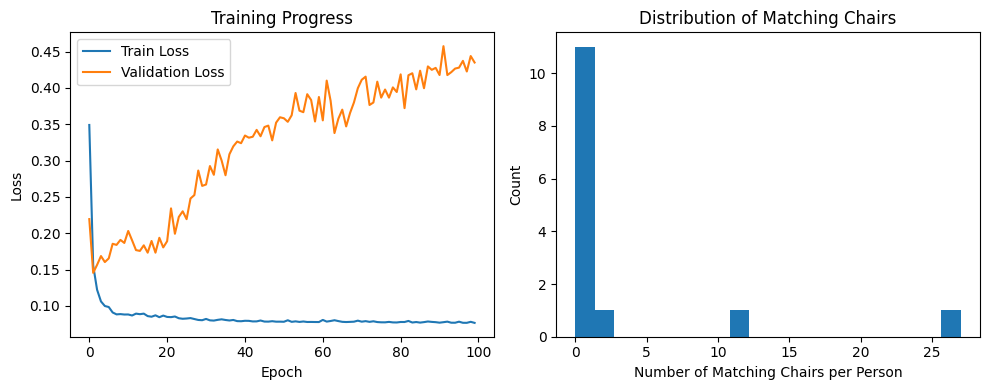

평균 매칭 의자 수: 3.00
최대 매칭 의자 수: 27
최소 매칭 의자 수: 0


In [12]:
# Cell 12: 결과 시각화
import matplotlib.pyplot as plt

# 학습 곡선 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()

# 매칭 조건 분포
plt.subplot(1, 2, 2)
match_counts = []
for i in range(len(person_df)):
    person_orig = person_df.iloc[i].values
    matches = 0
    for j in range(len(chair_processed)):
        if check_matching_conditions(person_orig, j, chair_df_original) == 1:
            matches += 1
    match_counts.append(matches)

plt.hist(match_counts, bins=20)
plt.xlabel('Number of Matching Chairs per Person')
plt.ylabel('Count')
plt.title('Distribution of Matching Chairs')

plt.tight_layout()
plt.show()

print(f"평균 매칭 의자 수: {np.mean(match_counts):.2f}")
print(f"최대 매칭 의자 수: {max(match_counts)}")
print(f"최소 매칭 의자 수: {min(match_counts)}")

In [13]:
# Cell 13: 최종 추천 결과를 DataFrame으로 저장
def save_recommendations_to_df(model, person_test_df, chair_normalized_all, chair_names, k=5):
    """
    추천 결과를 DataFrame으로 저장
    """
    results = []
    
    # ID와 특성 분리
    test_person_ids = person_test_df['image-name'].tolist()
    test_feature_columns = ['A_Buttock-popliteal length', 'B_Popliteal-height', 
                           'C_Hip-breadth', 'F_Sitting-height', 'G_Shoulder-breadth']
    person_test_features = person_test_df[test_feature_columns].copy()
    
    # 전처리
    for col in test_feature_columns:
        person_test_features[col] = person_test_features[col] * 10
    person_test_features = person_test_features.fillna(person_df.mean())
    person_test_normalized = person_scaler.transform(person_test_features.values)
    
    for i in range(len(person_test_df)):
        person_id = test_person_ids[i]
        person_features_test = person_test_normalized[i]
        
        # Top-K 추천
        top_k_indices, top_k_scores = get_top_k_recommendations(
            model, person_features_test, chair_normalized_all, k=k
        )
        
        for rank, (idx, score) in enumerate(zip(top_k_indices, top_k_scores), 1):
            chair_name = chair_names[idx]
            
            # 매칭 조건 확인
            person_orig = person_test_features.iloc[i].values
            match_status = check_matching_conditions(person_orig, idx, chair_df_original)
            
            results.append({
                'Person_ID': person_id,
                'Rank': rank,
                'Chair_Index': idx,
                'Chair_Name': chair_name,
                'Matching_Score': score,
                'Conditions_Met': 'Yes' if match_status == 1 else 'No'
            })
    
    results_df = pd.DataFrame(results)
    return results_df

# 추천 결과 저장
recommendations_df = save_recommendations_to_df(
    model, person_test_df, chair_normalized_all, chair_names, k=5
)

# 결과 출력
print("\n=== 추천 결과 요약 ===")
print(recommendations_df.head(15))

# 조건 만족 비율 계산
condition_met_ratio = recommendations_df.groupby('Person_ID')['Conditions_Met'].apply(
    lambda x: (x == 'Yes').sum() / len(x)
).mean()
print(f"\n평균 조건 만족 비율: {condition_met_ratio:.2%}")

# CSV로 저장
recommendations_df.to_csv('chair_recommendations.DualVAE.csv', index=False)
print("\n추천 결과가 'chair_recommendations.DualVAE.csv'에 저장되었습니다.")


=== 추천 결과 요약 ===
   Person_ID  Rank  Chair_Index Chair_Name  Matching_Score Conditions_Met
0        할머니     1           32   Chair_32        0.014821             No
1        할머니     2           48   Chair_48        0.014820             No
2        할머니     3           47   Chair_47        0.014819             No
3        할머니     4           66   Chair_66        0.014815             No
4        할머니     5           67   Chair_67        0.014815             No
5         다온     1           93   Chair_93        0.003122             No
6         다온     2           92   Chair_92        0.003096             No
7         다온     3           97   Chair_97        0.001005             No
8         다온     4          104  Chair_104        0.000623             No
9         다온     5          105  Chair_105        0.000622             No
10        민아     1           93   Chair_93        0.001075             No
11        민아     2           97   Chair_97        0.000912             No
12        민아     3  